In [43]:
import pandas as pd
import numpy as np
import time
import joblib

# Training Test
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

# Algorithms
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

# Load and Prepro

In [44]:
# Load data
data = pd.read_csv('data/heart.csv')

# remove duplicates
data = data.drop_duplicates()
print(data.shape)

# Train test sets
X = data.drop(columns='output')
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)

# Preprocessor
num_var = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
# cat_var = [col for col in X_train.columns if col not in num_var]

num_prep = ColumnTransformer([('num_prepo', StandardScaler(), num_var)],
                             remainder='passthrough')

(302, 14)
(241, 13) (241,) (61, 13) (241,)


In [45]:
tree_classifiers = {
  "Extra Trees": ExtraTreesClassifier(random_state=0),
  "Random Forest":RandomForestClassifier(random_state=0),
  "AdaBoost": AdaBoostClassifier(random_state=0),
  "Skl GBM": GradientBoostingClassifier(random_state=0),
  "Skl HistGBM": HistGradientBoostingClassifier(random_state=0),
  "XGBoost": XGBClassifier(),
  "LightGBM": LGBMClassifier(random_state=0),
  "CatBoost": CatBoostClassifier(random_state=0)}

tree_classifiers_pipe = {name: make_pipeline(num_prep, model) for name, model in tree_classifiers.items()}

# Benchmark accuracy

In [46]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Mean_cross_val':[], 'Time': []})

for model_name, model in tree_classifiers_pipe.items():
    start_time = time.time()
    
    # Training
    model.fit(X_train, y_train)
    
    # Prediction
    pred = model.predict(X_test)

    total_time = time.time() - start_time # Time taken to fit and predict

    model_results = pd.DataFrame({"Model":    [model_name],
                              "Accuracy": [accuracy_score(y_test, pred)*100],
                              "Mean_cross_val": cross_val_score(model, X_train, y_train).mean(),
                              "Time":     [total_time]})
    results = pd.concat([results, model_results])
    
    

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.005611
0:	learn: 0.6889865	total: 1.77ms	remaining: 1.77s
1:	learn: 0.6848531	total: 3.42ms	remaining: 1.71s
2:	learn: 0.6809871	total: 5.34ms	remaining: 1.78s
3:	learn: 0.6763709	total: 6.92ms	remaining: 1.72s
4:	learn: 0.6724458	total: 8.52ms	remaining: 1.7s
5:	learn: 0.6680178	total: 10.1ms	remaining: 1.68s
6:	learn: 0.6639458	total: 11.6ms	remaining: 1.65s
7:	learn: 0.6593551	total: 13.2ms	re

,Model,Accuracy,Mean_cross_val,Time
0,AdaBoost,91.803279,0.763776,0.104645
1,Extra Trees,88.524590,0.805272,0.216436
2,Random Forest,86.885246,0.826105,0.197636
3,CatBoost,86.885246,0.813605,1.954611
4,Skl GBM,81.967213,0.776190,0.102275
5,XGBoost,81.967213,0.801105,0.123427
6,LightGBM,80.327869,0.809439,0.071162
7,Skl HistGBM,78.688525,0.796939,0.354842


# Data augmentation

In [47]:
def data_enhancement(data):
    np.random.seed(0)
    gen_data = data.copy()
    sep_on = 'sex'
    divide_std_by = 10
    
    for value in data[sep_on].unique():
        sub_data =  gen_data[gen_data[sep_on] == value]

        age_std = sub_data['age'].std()
        
        trtbps_std = sub_data['trtbps'].std()
       
        chol_std = sub_data['chol'].std()
      
        thalachh_std = sub_data['thalachh'].std()
    
        oldpeak_std = sub_data['oldpeak'].std()
     
        
        for i in gen_data[gen_data[sep_on] == value].index:
            if np.random.randint(2) == 1:
                gen_data.loc[i,'age'] += age_std/divide_std_by
            else:
                gen_data.loc[i,'age'] -= age_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'trtbps'] += trtbps_std/divide_std_by
            else:
                gen_data.loc[i,'trtbps'] -= trtbps_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'chol'] += chol_std/divide_std_by
            else:
                gen_data.loc[i,'chol'] -= chol_std/divide_std_by
                
            if np.random.randint(2) == 1:
                gen_data.loc[i,'thalachh'] += thalachh_std/divide_std_by
            else:
                gen_data.loc[i,'thalachh'] -= thalachh_std/divide_std_by

            if np.random.randint(2) == 1:
                gen_data.loc[i,'oldpeak'] += oldpeak_std/divide_std_by
            else:
                gen_data.loc[i,'oldpeak'] -= oldpeak_std/divide_std_by

    return gen_data




In [48]:
gen = data_enhancement(data)
np.random.seed(0)
gen = gen.sample(frac=1)
extra_data = gen.sample(gen.shape[0] // 5)


X_train_aug = pd.concat([X_train, extra_data.drop(['output'], axis=1) ])
y_train_aug = pd.concat([y_train, extra_data['output'] ])

print(f'Augmented X_train by {((len(X_train_aug) - len(X_train)) / len(X_train)) * 100 }%')

Augmented X_train by 24.896265560165975%


In [49]:
X_train.shape, X_train_aug.shape

((241, 13), (301, 13))

In [50]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [51]:
gen.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
226,62.883684,1,1,121.669152,285.264976,0,0,100.586895,0,1.28251,1,1,3,0
152,64.883684,1,3,168.330848,222.735024,0,0,152.586895,0,0.71749,1,0,3,1
229,64.883684,1,2,123.330848,313.264976,0,1,133.413105,1,1.68251,1,0,3,0
202,58.883684,1,0,151.669152,265.735024,0,0,113.413105,1,0.68251,2,0,3,0
52,62.883684,1,2,131.669152,235.264976,0,1,143.586895,0,1.91749,1,3,3,1


In [53]:
tree_classifiers_pipe_aug = {name: make_pipeline(num_prep, model) for name, model in tree_classifiers.items()}
results_aug = pd.DataFrame({'Model': [], 'Accuracy': [],"Mean_cross_val":[], 'Time': []})

for model_name, model in tree_classifiers_pipe_aug.items():
    start_time = time.time()
    
    # Training
    model.fit(X_train_aug, y_train_aug)
    
    # Prediction
    pred_aug = model.predict(X_test)

    total_time = time.time() - start_time # Time taken to fit and predict

    model_results_aug = pd.DataFrame({"Model":    [model_name],
                              "Accuracy": [accuracy_score(y_test, pred_aug)*100],
                              "Mean_cross_val":cross_val_score(model, X_train_aug, y_train_aug).mean(), 
                              "Time":     [total_time]})


    results_aug = pd.concat([results_aug, model_results_aug])
    results_ord_aug = results_aug.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord_aug

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.00617
0:	learn: 0.6877408	total: 3.27ms	remaining: 3.27s
1:	learn: 0.6830655	total: 5.25ms	remaining: 2.62s
2:	learn: 0.6786623	total: 7.29ms	remaining: 2.42s
3:	learn: 0.6727525	total: 9.19ms	remaining: 2.29s
4:	learn: 0.6679884	total: 11ms	remaining: 2.18s
5:	learn: 0.6625347	total: 12.7ms	remaining: 2.11s
6:	learn: 0.6591892	total: 13.9ms	remaining: 1.98s
7:	learn: 0.6539974	total: 16.6ms	rema

,Model,Accuracy,Mean_cross_val,Time
0,Extra Trees,90.163934,0.867322,0.405201
1,Random Forest,88.524590,0.887268,0.306010
2,AdaBoost,88.524590,0.827432,0.113018
3,XGBoost,88.524590,0.857377,0.134999
4,CatBoost,88.524590,0.877322,2.652247
5,Skl HistGBM,86.885246,0.840710,0.430998
6,LightGBM,86.885246,0.857322,0.077116
7,Skl GBM,83.606557,0.834044,0.132039


C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


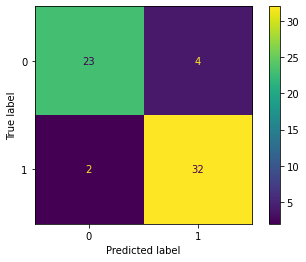

In [54]:

final_model = tree_classifiers_pipe_aug['Extra Trees']
final_model.fit(X_train_aug,y_train_aug)

pred_final = final_model.predict(X_test)
# print(classification_report(y_test, pred_final))
plot_confusion_matrix(final_model, X_test, y_test);

In [55]:
# Saving model
joblib.dump(final_model, 'model.joblib')

['model.joblib']

In [56]:
# example data for CLI
# X_test.head(10).to_csv('device/test_data.csv')

In [19]:
y_test.head(10)

226    0
152    1
229    0
202    0
52     1
246    0
176    0
169    0
224    0
218    0
Name: output, dtype: int64

# Hyperparameter tuning